## モデルの評価とハイパーパラメータのチューニングのベストプラクティス

#### &ensp;・機械学習のモデルの性能の評価
#### &ensp;・機械学習のアルゴリズムに共通する問題の診断
#### &ensp;・機械学習のモデルのチューニング
#### &ensp;・様々な性能指標に基づく予測モデルの評価

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

In [2]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df.shape

(569, 32)

In [9]:
df[1].value_counts()

B    357
M    212
Name: 1, dtype: int64

In [4]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values  # 細胞核のデジタル画像から算出された30個の実数値特徴量
y = df.loc[:, 1].values  # 診断結果M：悪性、B：良性
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [10]:
le.transform(['M', 'B'])  #M:1,B:0

array([1, 0])

In [11]:
from sklearn.model_selection import train_test_split

# データセットを8：2に分割
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

### パイプラインを作ると何が嬉しいか

#### &emsp;・各データに対するスケーリングや圧縮のためのコードが簡素化
#### &emsp;・さまざまな変換器や推定器を1つのメソッドのように使える

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),　　# データセットの標準化
                        PCA(n_components=2), # 30次元　-> 2次元
                        LogisticRegression(random_state=1, solver='lbfgs'))　#ロジスティック回帰

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


In [20]:
pipe_lr.get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('pca',
   PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
       svd_solver='auto', tol=0.0, whiten=False)),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='warn', n_jobs=None, penalty='l2',
                      random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'pca': PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_ite

### モデルの性能評価

#### &emsp;モデルの汎化性能を的確に推定する
#### &emsp;バイアスとバリアンスの適度なバランスを取る

#### ホールドアウト法
##### &emsp;・訓練データ、検証データ、テストデータにわける
##### &emsp;・問題点　-> 訓練データセットをどのように分割するかによって性能の評価に影響が及ぶ場合がある

#### k分割交差検証
##### &emsp;・訓練データをランダムにk個に分割、ｋ−１個で訓練を行い、1個を性能の評価に使う。これをk回繰り返し、ｋ個のモデルを取得
##### &emsp;・満足のいく汎化性能が得られる最適なハイパーパラメータをみつけるために使う
##### &emsp;・満足のいくハイパーパラメータが見つかったら訓練データセット全体でモデルを再び訓練する　-> ロバストなモデル

#### 参考：https://www.researchgate.net/profile/Ron-Kohavi/publication/2352264_A_Study_of_Cross-Validation_and_Bootstrap_for_Accuracy_Estimation_and_Model_Selection/links/02e7e51bcc14c5e91c000000/A-Study-of-Cross-Validation-and-Bootstrap-for-Accuracy-Estimation-and-Model-Selection.pdf

#### 層化k分割交差検証

##### &emsp;クラスの比率が均等ではないケースでは評価のバイアスとバリアンスが改善される
##### &emsp;層化交差検証では各サブセットでのクラスラベルの比率が維持される

In [24]:
X_train.shape, y_train.shape

((455, 30), (455,))

In [33]:

import numpy as np
from sklearn.model_selection import StratifiedKFold
    

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    print(train[0:9], test[0:9])
    pipe_lr.fit(X_train[train], y_train[train])  # ロジスティック回帰パイプラインをそれぞれのデータセットで学習
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score)) 
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

[45 46 47 48 50 51 52 53 54] [0 1 2 3 4 5 6 7 8]
Fold:  1, Class dist.: [256 153], Acc: 0.935
[0 1 2 3 4 5 6 7 8] [45 46 47 48 50 51 52 53 54]
Fold:  2, Class dist.: [256 153], Acc: 0.935
[0 1 2 3 4 5 6 7 8] [85 87 88 89 90 93 94 95 97]
Fold:  3, Class dist.: [256 153], Acc: 0.957
[0 1 2 3 4 5 6 7 8] [132 133 134 135 136 139 140 141 143]
Fold:  4, Class dist.: [256 153], Acc: 0.957
[0 1 2 3 4 5 6 7 8] [177 178 182 183 184 185 188 189 191]
Fold:  5, Class dist.: [256 153], Acc: 0.935
[0 1 2 3 4 5 6 7 8] [227 229 230 231 233 234 235 237 238]
Fold:  6, Class dist.: [257 153], Acc: 0.956
[0 1 2 3 4 5 6 7 8] [271 272 273 274 275 276 277 279 280]
Fold:  7, Class dist.: [257 153], Acc: 0.978
[0 1 2 3 4 5 6 7 8] [315 316 317 318 320 322 326 327 328]
Fold:  8, Class dist.: [257 153], Acc: 0.933
[0 1 2 3 4 5 6 7 8] [364 366 367 368 369 370 371 372 373]
Fold:  9, Class dist.: [257 153], Acc: 0.956
[0 1 2 3 4 5 6 7 8] [409 411 412 413 414 415 416 417 418]
Fold: 10, Class dist.: [257 153], Acc: 0.9

In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,  # サブセットごとの評価の計算処理をマシン上の複数のCPUに分散させる
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


### 学習曲線と検証曲線によるアルゴリズムの診断

#### バイアスとバリアンスの診断

#### &emsp;モデルの自由度が高かったり、パラメータが多すぎたりする場合、モデルは訓練データを過学習する傾向にある

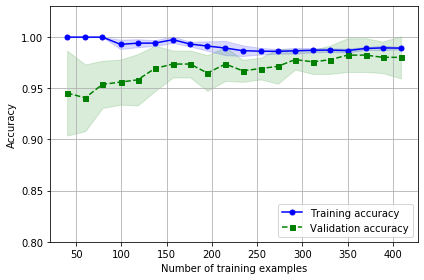

In [82]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1,
                                           solver='lbfgs', max_iter=10000))  # イテレーション回数を増やして、データセットのサイズが小さい場合や正則化パラメータの値が極端な場合の収束問題を回避

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 20),  # 学習曲線を生成するために使用する訓練データ
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

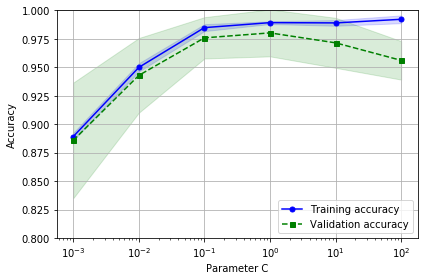

In [44]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

##### 逆正則化パラメータCを小さくして正則化の強さを上げると、モデルが少し学習不足に陥る

##### Cの値を大きくして正則化の強さを下げるとモデルに過学習の傾向が見られる 

##### C = 0.01 ~ 0.1が適切

In [45]:
train_scores1

array([[0.89486553, 0.88508557, 0.88997555, 0.88753056, 0.89242054,
        0.88536585, 0.88536585, 0.89268293, 0.88780488, 0.8902439 ],
       [0.95110024, 0.94376528, 0.95354523, 0.94865526, 0.95599022,
        0.95121951, 0.94634146, 0.95365854, 0.94634146, 0.94878049],
       [0.98777506, 0.98533007, 0.98288509, 0.9804401 , 0.99022005,
        0.98780488, 0.98536585, 0.9804878 , 0.98536585, 0.98292683],
       [0.98777506, 0.98777506, 0.99022005, 0.99022005, 0.99022005,
        0.9902439 , 0.9902439 , 0.98780488, 0.9902439 , 0.98780488],
       [0.98533007, 0.98777506, 0.98533007, 0.99266504, 0.99266504,
        0.9902439 , 0.9902439 , 0.98780488, 0.9902439 , 0.98780488],
       [0.99022005, 0.99022005, 0.99022005, 0.99511002, 1.        ,
        0.9902439 , 0.9902439 , 0.99512195, 0.99268293, 0.98780488]])

### グリッドサーチ

#### ハイパーパラメータの最適な組み合わせを見つけ出すことによりモデルの性能をさらに改善する

In [110]:

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] # 数値を指定

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range,  # Cおよびgammaをチューニング
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,  # 
                  cv=10,
                  n_jobs=-1)  # 並列処理
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [111]:
gs.cv_results_

{'mean_fit_time': array([0.00647607, 0.00471056, 0.00288725, 0.00310123, 0.00312705,
        0.00422761, 0.01341989, 0.04598105, 0.00691535, 0.00703661,
        0.00769782, 0.00692263, 0.01096346, 0.01230624, 0.0079711 ,
        0.00718682, 0.00784044, 0.00742979, 0.00971351, 0.00682979,
        0.00845819, 0.00992827, 0.00987842, 0.00876343, 0.00852458,
        0.00689142, 0.00679328, 0.00719333, 0.00988741, 0.01176617,
        0.01299455, 0.01065326, 0.00686312, 0.0071285 , 0.00822203,
        0.00757799, 0.01070638, 0.0120822 , 0.01034696, 0.00923882,
        0.00712848, 0.00466905, 0.003123  , 0.00494907, 0.00994401,
        0.01275189, 0.01036351, 0.00995729, 0.00584762, 0.00336056,
        0.00293741, 0.00633745, 0.01072009, 0.01339872, 0.01116602,
        0.01089661, 0.00559151, 0.00297718, 0.00325387, 0.00538239,
        0.01064191, 0.01372778, 0.01066236, 0.00985258, 0.00353587,
        0.00434313, 0.00327802, 0.00499394, 0.01136019, 0.01315553,
        0.00889633, 0.0100863 ]

In [47]:
clf = gs.best_estimator_

# clf.fit(X_train, y_train) 
# note that we do not need to refit the classifier
# because this is done automatically via refit=True.

print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


### グリッドサーチ×ｋ分割交差検証

#### 入れ子式の交差検証を使ったときにはテストデータセットを基準として、評価の真の誤差にほとんどバイアスがないという結論もある

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-91

In [112]:

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy（SVM): %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV accuracy（SVM): 0.974 +/- 0.015


In [113]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy（決定木）: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV accuracy（決定木）: 0.934 +/- 0.016


### ROC曲線（受信者操作特性曲線）

#### &emsp;性能に基づいて分類モデルを選択するためのツール
#### &emsp;分類器のしきい値を変えることによって計算される偽陽性率と真陽性率が選択の基準
#### &emsp;分類モデルの性能を明らかにするためにROC曲線に基づいて曲線下面積を計算できる
#### &emsp;二値分類に特化

$$TPR = \frac{TP}{P} = \frac{TP}{FN + TP}$$

$$FPR =  \frac{FP}{N} = \frac{FP}{FP + TN}$$

#### 不均衡なクラスの問題に特に役立つ性能指標

[1.98224906 0.98224906 0.7766306  0.73609188 0.71344002 0.70577078
 0.63969659 0.62669849 0.61630231 0.61002401 0.59794661 0.59588502
 0.59330029 0.59295242 0.56209954 0.54907242 0.53193713 0.52595145
 0.48849083 0.44989164 0.44342728 0.4074998  0.38821395 0.38474849
 0.38460586 0.37725276 0.35212156 0.34483707 0.34163363 0.33748221
 0.32685452 0.30349941 0.30041053 0.29511126 0.29085561 0.24980093
 0.24824036 0.24735944 0.24681062 0.24585292 0.23979563 0.2318999
 0.23162691 0.23137613 0.23060651 0.22696131 0.22096655 0.20667282
 0.20527989 0.201389   0.19194633 0.1832465  0.17021846 0.13622575
 0.13600656 0.01715432]
[0.43525079 0.10104529 0.54907242 0.24980093 0.13886133 0.45936303
 0.13711278 0.201389   0.46207897 0.28516861 0.27801524 0.01715432
 0.08838012 0.26185895 0.09554096 0.68933455 0.44989164 0.60150763
 0.4074998  0.23060651 0.64974437 0.61630231 0.13622575 0.38460586
 0.42831103 0.71344002 0.41263884 0.24585292 0.52595145 0.44342728
 0.50054659 0.8567243  0.20686036 0.306

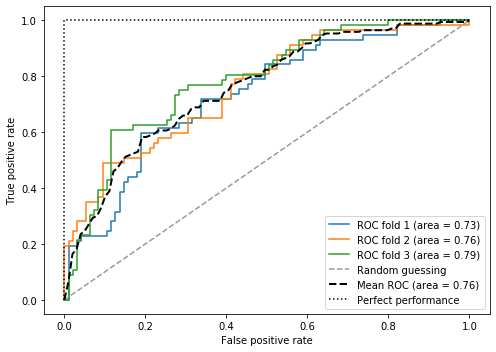

In [117]:

from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp

# パイプラインのインスタンス化
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))
# 2つの特徴量を抽出
X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    # predict_probaメソッドで確率を予測、fitメソッドでモデルに適合させる
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    # roc_curve関数でROC曲線の性能を計算してプロット
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr) # fpr(x),tpr(y)を線形補間
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)  # AUCの計算
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
print(thresholds)
# print(pipe_lr.decision_func)
# print(y_train[test].shape)
print(probas[:,1])
print(tpr)
print(fpr)
print(f'fpr: {fpr.shape}, tpr: {tpr.shape}, thresholds: {thresholds.shape}')

# np.interp(x, xp, fp)
# xp = [1, 2, 3]
# fp = [3, 2, 0]
# np.interp(2.5, xp, fp)
# 1.0
# np.interp([0, 1, 1.5, 2.72, 3.14], xp, fp)
# array([3.  , 3.  , 2.5 , 0.56, 0.  ])
# UNDEF = -99.0
# np.interp(3.14, xp, fp, right=UNDEF)
# -99.0

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)

#### しきい値に対応する点

#### しきい値を1.0付近にするとどれも陽性グループに入らない。０％

#### しきい値を0付近にすると、すべて陽性にする入るので、感度、偽陽性率は1.0グラフ最右上に打たれる

https://cse.hkust.edu.hk/nevinZhangGroup/readings/yi/Bradley_PR97.pdf

https://www.cresco.co.jp/blog/entry/15337/

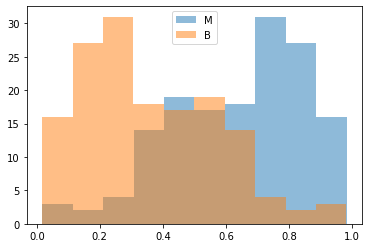

In [88]:
plt.hist(probas[:, 0], alpha=0.5, label='M')
plt.hist(probas[:, 1], alpha=0.5, label='B')
plt.legend()
plt.show()

Text(0.5, 1.0, 'thresholds')

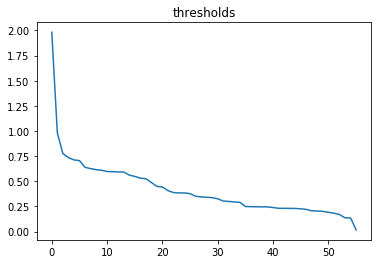

In [116]:

plt.plot(thresholds)
plt.title('thresholds')

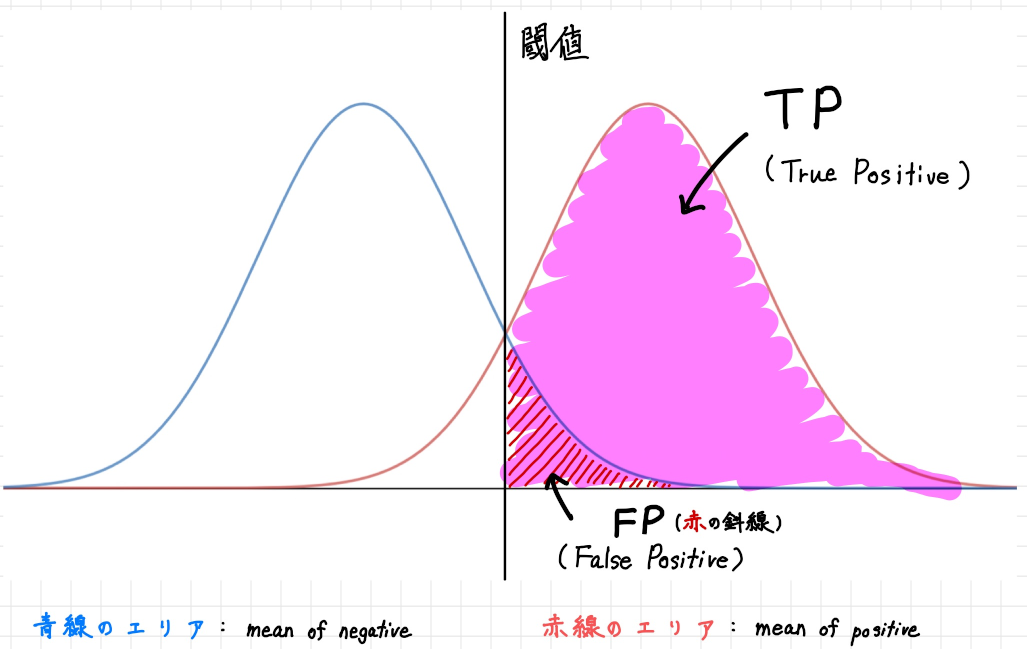

In [68]:
from IPython.display import Image
Image(filename='thresholds.jpg', width=600)

https://qiita.com/TsutomuNakamura/items/ef963381e5d2768791d4


### クラスの不均衡に対処する

#### テストデータセットの９０％が健康な患者データ

#### -> ９０％のテスト正解率を達成するモデルを訓練することはデータセットで提供される特徴量から有益なモデルが得られない

In [92]:
# 不均衡なデータの作成
X_imb = np.vstack((X[y == 0], X[y == 1][:40])) #すべての良性データ点を選択肢、最初の悪性腫瘍データと結合
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [53]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [54]:

from sklearn.utils import resample

print('Number of class 1 examples before:', X_imb[y_imb == 1].shape[0])

# データ点の個数がクラス０と同じになるまで新しいデータ点復元抽出
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])

Number of class 1 examples before: 40
Number of class 1 examples after: 357


In [55]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [94]:
X_imb[y_imb==0].shape

(357, 30)

In [56]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

##### 機械学習のアルゴリズムはコスト関数や報酬を最適化するモデル
##### -> アルゴリズムが暗黙的に学習するモデルは、データセットの大多数を占めるクラスに基づいて予測を最適化するモデル

##### 少数派クラスの不均衡な割合に対処する方法　ー> 少数派クラスに関する誤った予測に大きなペネルティを科す
##### class_weight = 'balanced'

https://www.jair.org/index.php/jair/article/view/10302

https://github.com/scikit-learn-contrib/imbalanced-learn